In [1]:
import sys
sys.path.append('../') 
sys.path.append('../../') 
import numpy as np
import pandas as pd
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge
from scipy.stats import zscore, mstats
from CLR.constrained_linear_regression import ConstrainedLinearRegression
import quantutils.regression_utils as regutils
%load_ext autoreload
%autoreload 2

In [2]:
df_monthly = pd.read_excel('../Data/sample_data.xlsx', skiprows=1)
df_monthly.columns = ['Date', 'CPI-U_SA', 'CPI-U_NSA', 'Manheim_Used_Vehicle', 'PPI_Used_Vehicles', 'PPI_Automotive', 'PPI_Passenger_Cars', '5y_Treasury']
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly.set_index('Date', inplace=True)


In [39]:
df_coefs_dict = {}
df_coefs_dict['predictions'] = []
df_feature = pd.read_csv('../Data/df_feature.csv', index_col=0, parse_dates=True)
df_feature = df_feature.iloc[:, :2]
df_feature['target'] = df_feature['UTD@CPIDATA_sa_pct_change_l0_ma2'].shift(-2)
df_regression = df_feature.copy()
windows = [50, 70]
last_number = 2
for window in (windows):
    df_results, fitted_models, X_series, y_series = regutils.rolling_regression_sklearn_advanced(df_regression, rolling_window=window, l1_ratio=0.1, dropna=True, shift_window=last_number)
    df_coefs_dict['predictions'].append(df_results[['predictions']].rename(columns={f'predictions': f'predictions_{window}'}).squeeze())
df_coefs_dict['predictions'] = pd.concat(df_coefs_dict['predictions'], axis=1).dropna()
# name of the selected target is the same

c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:114: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=datac.index, name='predictions')
c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:118: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  intercept = pd.Series(index=datac.index, name='intercept')
c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:114: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=datac.index, name='predictions')
c:\Users\Wazir\Documents\wazewww\Macro\Regre

In [18]:
regression_streamlit_state = {'df_coefs_dict': df_coefs_dict, 'df_transformed':df_feature,
                              'selected_target': 'target'
                              }
regutils.generate_stats_table(regression_streamlit_state)

,metrics,model,value
0,r2,predictions_50,0.037778
1,r2,predictions_70,0.040579
2,rmse,predictions_50,0.013470
3,rmse,predictions_70,0.013450
4,mae,predictions_50,0.007710
5,mae,predictions_70,0.007679
6,corr,predictions_50,0.270185
7,corr,predictions_70,0.282684
8,hit_rate,predictions_50,0.241706
9,hit_rate,predictions_70,0.317536


In [44]:
df_feature.dropna().head()

,UTD@CPIDATA_sa_pct_change_l0_ma2,UTD@CPIDATA_sa_pct_change_l0_ma3,target
2000-04-30,0.003453,0.001454,0.003327
2000-05-31,0.005471,0.004534,-0.000884
2000-06-30,0.003327,0.003632,-0.001456
2000-07-31,-0.000884,0.001643,0.004144
2000-08-31,-0.001456,-0.000985,0.010082


In [34]:
np.linalg.svd(df_feature.drop('target', axis=1).cov())[1].round(5)

array([2.8e-04, 1.0e-05])

In [14]:
dir(regutils)

['ConstrainedLinearRegression',
 'ElasticNet',
 'Ridge',
 'StandardScaler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'feature_engineering',
 'generate_stats_table',
 'lag_variables',
 'make_pipeline',
 'mean_absolute_directional_loss',
 'mean_absolute_error',
 'mean_squared_error',
 'mstats',
 'natural_lag',
 'np',
 'pd',
 'r2_score',
 'rolling_regression_sklearn_advanced',
 'time',
 'zscore']

In [37]:
df_results, fitted_models, X_series, y_series = regutils.rolling_regression_sklearn_advanced(df_regression, rolling_window=window, l1_ratio=0.05, dropna=True, shift_window=last_number,
                                                                                             ridge_proportion=True)


c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:114: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=datac.index, name='predictions')
c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:118: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  intercept = pd.Series(index=datac.index, name='intercept')


In [38]:
df_results_ridge, fitted_models, X_series, y_series = regutils.rolling_regression_sklearn_advanced(df_regression, rolling_window=window, l1_ratio=0.005, dropna=True, shift_window=last_number)


c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:114: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=datac.index, name='predictions')
c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:118: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  intercept = pd.Series(index=datac.index, name='intercept')


In [27]:
df_feature.corr()

,UTD@CPIDATA_sa_pct_change_l0_ma2,UTD@CPIDATA_sa_pct_change_l0_ma3,target
UTD@CPIDATA_sa_pct_change_l0_ma2,1.000000,0.931769,0.321642
UTD@CPIDATA_sa_pct_change_l0_ma3,0.931769,1.000000,0.208287
target,0.321642,0.208287,1.000000


<Axes: >

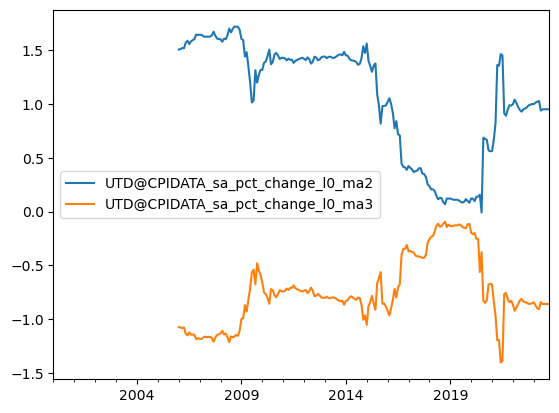

In [24]:
df_results.drop('predictions', axis=1).plot()

<Axes: >

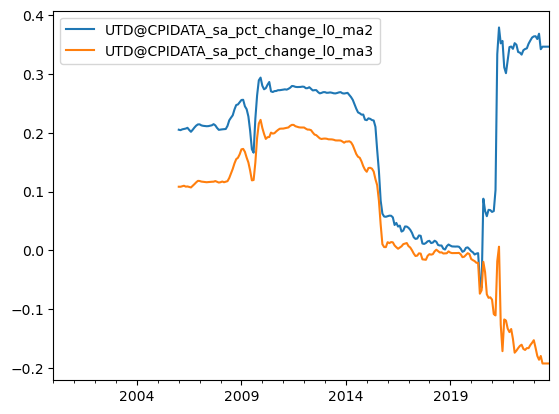

In [25]:
df_results_ridge.drop('predictions', axis=1).plot()

<Axes: xlabel='predictions', ylabel='target'>

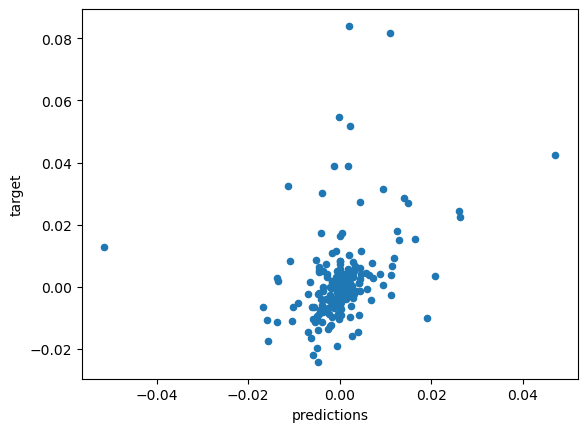

In [84]:
df_res.plot.scatter('predictions', 'target')